In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import percentile
from numpy.random import randn
import numpy as np
import os
from scipy.stats import norm, stats

In [293]:
def createStateDf(state, year):
    folder = "data/WICAgencies{}ytd/".format(year)
    
    stateDict = {
        "Date": pd.read_csv("data/WICAgencies{}ytd/Children_Participating.csv".format(year)).columns[1:-1]
    }
    
    for dataFile in os.listdir(folder):
        file = folder + dataFile
        stateDf = pd.read_csv(file).dropna()
        
        
        if len(stateDf.columns) == 14:
            stateData = stateDf[ stateDf[stateDf.columns[0]] == state ]
         
            stateData = np.array(stateDf[ stateDf[stateDf.columns[0]] == state ]).flatten()
            stateData = stateData[1:-1]
            
            stateDict[str(dataFile)[0:-4]] = stateData
            
    return pd.DataFrame(stateDict).drop()
                

def createFourYearDf(state):
    years = ["2013", "2014", "2015", "2016"]
    returnDf = pd.DataFrame()
    
    for year in years:
        returnDf = pd.concat([returnDf, createStateDf(state, year)], axis=0)
    
    return returnDf.reset_index(drop=True)

dfNewYork = createFourYearDf("New York")

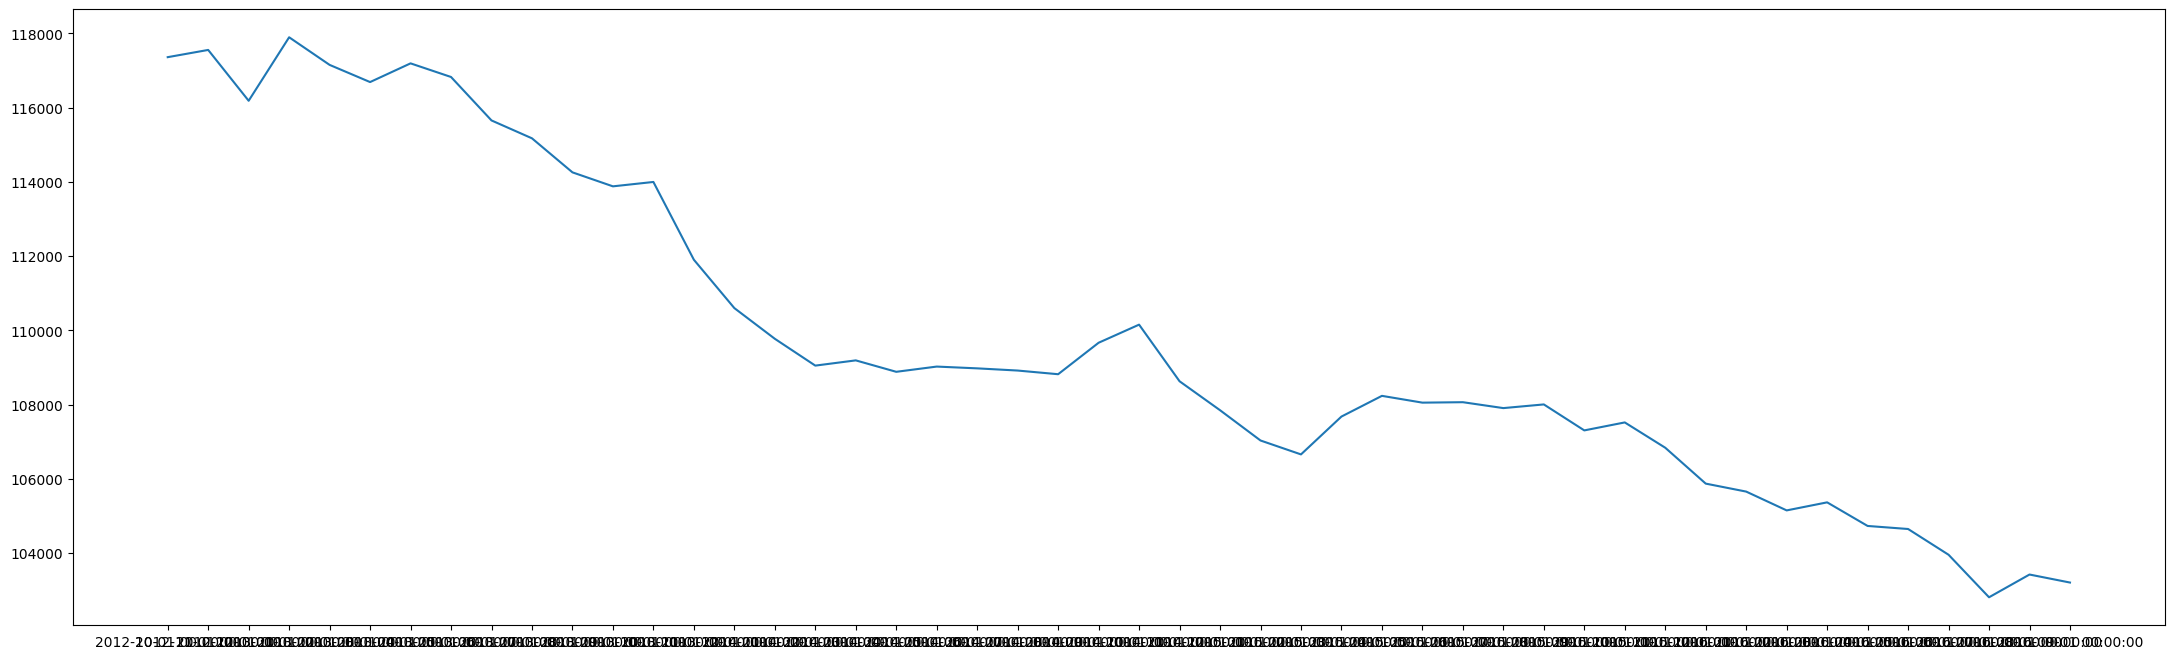

In [295]:

plt.figure(figsize=(27, 8))
plt.plot(dfNewYork["Date"], dfNewYork["Total_Infants"])
plt.show()

In [ ]:
def createGraph(df):
    

In [275]:
dfNewYork

,Date,Infants_Partially_Breastfed,Total_Infants,Total_Breastfeeding_Women,Total_Number_of_Participants,Pregnant_Women_Participating,Postpartum_Women_Participating,Average_Food_Cost_Per_Person,Infants_Fully_Breastfed,Food_Costs,Children_Participating,Women_Partially_Breastfeeding,Infants_Fully_Formula-fed,Rebates_Received,Women_Fully_Breastfeeding,Total_Women
0,2013-10-01 00:00:00,40734.0,117361.0,50125.0,520563.0,48552.0,25671.0,55.5547,9172.0,28919717.0,278854.0,39937.0,67455.0,9690782.0,10188.0,124348.0
1,2013-11-01 00:00:00,41071.0,117556.0,50381.0,515920.0,46343.0,26239.0,58.55,9092.0,30207094.0,275401.0,40224.0,67393.0,8410948.0,10157.0,122963.0
2,2013-12-01 00:00:00,40395.0,116186.0,49675.0,506444.0,44639.0,25911.0,56.1518,8915.0,28437767.0,270033.0,39724.0,66876.0,9727785.0,9951.0,120225.0
3,2014-01-01 00:00:00,41103.0,117897.0,50725.0,514810.0,45281.0,26795.0,57.2702,9017.0,29483293.0,274112.0,40584.0,67777.0,9672216.0,10141.0,122801.0
4,2014-02-01 00:00:00,40525.0,117153.0,50200.0,513555.0,45320.0,26109.0,57.7211,9012.0,29642985.0,274773.0,40109.0,67616.0,9070529.0,10091.0,121629.0
5,2014-03-01 00:00:00,40303.0,116690.0,49850.0,513212.0,46181.0,25412.0,54.3802,8981.0,27908564.0,275079.0,39769.0,67406.0,10418205.0,10081.0,121443.0
6,2014-04-01 00:00:00,40300.0,117194.0,50099.0,516787.0,47108.0,24888.0,58.8335,9134.0,30404404.0,277498.0,39802.0,67760.0,8569026.0,10297.0,122095.0
7,2014-05-01 00:00:00,40036.0,116827.0,49870.0,517318.0,47875.0,24567.0,56.8988,9219.0,29434759.0,278179.0,39543.0,67572.0,9476671.0,10327.0,122312.0
8,2014-06-01 00:00:00,39422.0,115656.0,48999.0,513932.0,47451.0,24110.0,56.3175,9084.0,28943361.0,277716.0,38841.0,67150.0,10031097.0,10158.0,120560.0
9,2014-07-01 00:00:00,39300.0,115174.0,49005.0,511054.0,47050.0,23636.0,56.4457,8983.0,28846816.0,276189.0,38890.0,66891.0,9819649.0,10115.0,119691.0
